In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import jax.numpy as jnp
import jax
jax.config.update('jax_enable_x64',True)
import triangle
import matplotlib.pyplot as plt
from lm import LM
import scipy as sp
jnp.set_printoptions(precision=4,linewidth=120)


In [3]:
Nside=36
Nsquare=Nside*4
v=np.linspace(0,1,Nside,endpoint=False)
z=np.zeros(Nside)
o=np.ones(Nside)
square=np.c_[np.r_[v,o,1-v,z],np.r_[z,v,o,1-v]]
square_seg = np.c_[np.arange(square.shape[0]-1),np.arange(1,square.shape[0])]
square_seg = np.r_[square_seg,np.array([[square.shape[0]-1,0]])]

Ncircle = 72
r=0.2
cx,cy=0.35,0.5
theta = np.linspace(0, 2 * np.pi, Ncircle, endpoint=False)
circle = np.stack([r*np.cos(theta)+cx, r*np.sin(theta)+cy], axis=1)
circle_seg = np.c_[np.arange(circle.shape[0]-1), np.arange(1,circle.shape[0])]
circle_seg = np.r_[circle_seg,np.array([[circle.shape[0]-1,0]])]
circle_seg+=square.shape[0]

square_normals = np.zeros((Nsquare,2))
square_normals[1:Nside] = np.array([0.,1.])
square_normals[Nside+1:2*Nside] = np.array([-1.,0.])
square_normals[2*Nside+1:3*Nside] = np.array([0,-1.])
square_normals[3*Nside+1:4*Nside] = np.array([1.,0.])
a45 = np.sqrt(2)/2
square_normals[0] = np.array([a45, a45])
square_normals[Nside] = np.array([-a45, a45])
square_normals[2*Nside] = np.array([-a45, -a45])
square_normals[3*Nside] = np.array([a45, -a45])

circle_normals = np.c_[np.cos(theta), np.sin(theta)]
normals = np.r_[square_normals, circle_normals]
boundary = np.arange(Nsquare+Ncircle)

In [27]:
A = dict(vertices=np.r_[square,circle], segments=np.r_[square_seg,circle_seg], holes=[[cx, cy]])
B = triangle.triangulate(A, 'qpa0.0005D')

In [28]:
tr=B['triangles']
verts = B['vertices']
interior = np.where(np.ravel(B['vertex_markers'])==0)[0]
Ninterior=interior.size
Nverts = verts.shape[0]

def get_neighbors(i):
    return np.setdiff1d(np.unique(np.ravel(tr[np.where(tr==i)[0]])),i)

def get_five_neighbors(i):
    nb=get_neighbors(i)
    if nb.size<5:
        for ii in nb:
            nb=np.union1d(nb, get_neighbors(ii))
        nb=np.setdiff1d(nb,i)
    d=np.sum((verts[i]-verts[nb])**2,axis=1)
    if nb.size>5:
        return nb[np.argpartition(d,5)[:5]]
    else:
        return nb

# f = a0*x^2 + a1*y^2 + a2*x + a3*y + a4*xy + f0
# df/dx = 2a0*x + a2 + a4*y
# df/dy = 2a1*y + a3 + a4*x
# df2/dx2 = 2a0
# df2/dy2 = 2a1
# df2/dxdy = a4

def get_LU(i):
    n5 = get_five_neighbors(i)
    x,y = (verts[n5]-verts[i]).T
    return jax.scipy.linalg.lu_factor(np.c_[x**2, y**2, x, y, x*y]),n5

def get_LUs(idxs):
    LUs=[]
    pivs=[]
    n5s=[]
    for i in idxs:
        (LU, piv), n5 = get_LU(i)
        LUs.append(LU)
        pivs.append(piv)
        n5s.append(n5)
    n5s=jnp.stack(n5s)
    LUs=jnp.stack(LUs)
    pivs=jnp.stack(pivs)
    return LUs, pivs, n5s

all_verts = np.arange(Nverts)
LUs, pivs, n5s=get_LUs(all_verts)
lu_solve_vec=jax.vmap(jax.scipy.linalg.lu_solve,in_axes=((0,0),0))

@jax.jit
def get_coeffs(f):
    return lu_solve_vec((LUs, pivs), jnp.take(f,n5s)-f[:,None])


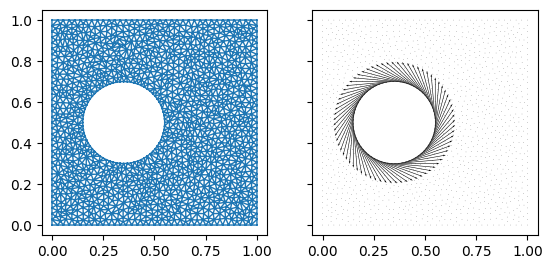

In [29]:

w=0.01
u=np.zeros(Nverts)
u[:Nsquare]=0.
u[Nsquare:Nsquare + Ncircle]=-r*w*np.sin(theta)
u[Nsquare+Ncircle:]=1e-6

v=np.zeros(Nverts)
v[:Nsquare]=0.
v[Nsquare:Nsquare + Ncircle]=r*w*np.cos(theta)
v[Nsquare+Ncircle:]=1e-6

p=jnp.zeros(Nverts)

u=jnp.asarray(u)
v=jnp.asarray(v)
fig1, ax = plt.subplots(1,2, sharex=True, sharey=True)
ax[0].set_aspect('equal')
_=ax[0].triplot(verts[:,0],verts[:,1],'-',triangles=tr,lw=1)
ax[1].set_aspect('equal')
_=ax[1].quiver(verts[:,0],verts[:,1], u, v, scale=0.01)

In [34]:

#Stokes flow
@jax.jit
def eqs(x, u=u, v=v):
    
    u=u.at[interior].set(x[:Ninterior])
    v=v.at[interior].set(x[Ninterior:2*Ninterior])
    ua=get_coeffs(u)
    va=get_coeffs(v)
    
    ueqs= (2*ua[interior,0] + 2*ua[interior,1])
    veqs= (2*va[interior,0] + 2*va[interior,1])
    return jnp.r_[ueqs, veqs]

xguess=np.r_[u[interior], v[interior]]
res=LM(eqs, xguess, L=1, rho_tol = 0.1, maxiter=100, xtol=1e-6, ftol=1e-10, iter_print=25)
usol=u.at[interior].set(res.x[:Ninterior])
vsol=v.at[interior].set(res.x[Ninterior:2*Ninterior])
ua=get_coeffs(usol)
va=get_coeffs(vsol)
print(np.max(np.abs(ua[interior,2] + va[interior,3])))

Levenberg-Marquadrt Jacobian shape: (2502, 2502)
Iteration: 10  L: 2.87e-10
f abs mean: 1.16e-14  max: 1.45e-13
0.0038017239557802847


In [8]:
rho=1000.

#pressure
@jax.jit
def eqs(p, ua=ua, va=va):

    pa=get_coeffs(p)
    peqs_interior = 2*(pa[interior,0]+pa[interior,1]) + rho*(ua[interior,2]**2 + 2*ua[interior,3]*va[interior,2] + va[interior,3]**2)
    peqs_boundary = jnp.sum(pa[boundary,2:4]*normals,axis=1) 
    return jnp.r_[peqs_interior, peqs_boundary]
    
res=LM(eqs, p, L=1000, rho_tol = 0.1, maxiter=200, xtol=1e-8, ftol=1e-10, iter_print=25)
psol=res.x

Levenberg-Marquadrt Jacobian shape: (1467, 1467)
Iteration: 24  L: 1.77e-06
f abs mean: 1.24e-04  max: 6.40e-03


In [9]:
rho=1000.
nu = 0.001
@jax.jit
def eqs(x, u=u, v=v):
    
    u=u.at[interior].set(x[:Ninterior])
    v=v.at[interior].set(x[Ninterior:2*Ninterior])
    p=x[2*Ninterior:]
    ua=get_coeffs(u)
    va=get_coeffs(v)
    pa=get_coeffs(p)
    
    ueqs= u[interior]*ua[interior,2] + v[interior]*ua[interior,3] + pa[interior,2]/rho - nu*(2*ua[interior,0] + 2*ua[interior,1])
    veqs= u[interior]*va[interior,2] + v[interior]*va[interior,3] + pa[interior,3]/rho - nu*(2*va[interior,0] + 2*va[interior,1])
    peqs_interior = 2*(pa[interior,0]+pa[interior,1]) + rho*(ua[interior,2]**2 + 2*ua[interior,3]*va[interior,2] + va[interior,3]**2)
    peqs_boundary = jnp.sum(pa[boundary,2:4]*normals,axis=1) 
    return jnp.r_[ueqs, veqs, peqs_interior, peqs_boundary]
    
xguess=np.r_[usol[interior], vsol[interior], psol]
res=LM(eqs, xguess, L=1000, rho_tol = 0.1, maxiter=200, xtol=1e-8, ftol=1e-10, iter_print=25)
usol=u.at[interior].set(res.x[:Ninterior])
vsol=v.at[interior].set(res.x[Ninterior:2*Ninterior])
psol=res.x[2*Ninterior:]
ua=get_coeffs(usol)
va=get_coeffs(vsol)
print(np.mean(np.abs(ua[interior,2] + va[interior,3])),np.max(np.abs(ua[interior,2] + va[interior,3])))

Levenberg-Marquadrt Jacobian shape: (3969, 3969)
Iteration: 25  L: 1.27e-03
f abs mean: 5.70e-05  max: 5.47e-03
Iteration: 50  L: 1.57e-03
f abs mean: 5.78e-05  max: 5.22e-03
Iteration: 75  L: 1.94e-03
f abs mean: 6.31e-05  max: 4.85e-03
Iteration: 100  L: 2.40e-03
f abs mean: 6.45e-05  max: 4.56e-03
Iteration: 125  L: 2.96e-03
f abs mean: 6.58e-05  max: 4.33e-03
Iteration: 150  L: 3.69e-05
f abs mean: 6.93e-05  max: 4.06e-03
Iteration: 175  L: 4.55e-05
f abs mean: 6.87e-05  max: 3.89e-03
0.00075282193026612 0.013271103951907975


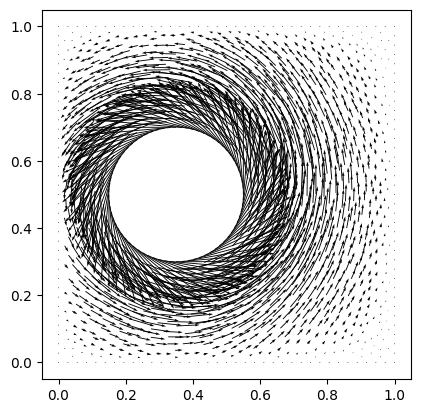

In [35]:

fig1, ax = plt.subplots(1,1, sharex=True, sharey=True)
ax.set_aspect('equal')
_=ax.quiver(verts[:,0],verts[:,1], usol, vsol, scale=0.008)

In [11]:
jnp.partition(psol,10)[:10]

Array([-0.0168, -0.0151, -0.0148, -0.0125, -0.0101, -0.0099, -0.0095, -0.0095, -0.0091, -0.0079], dtype=float64)